# SLCP with NRE

In [1]:
import torch
import torch.nn as nn

from datetime import datetime

from lampe.simulators.slcp import SLCP
from lampe.nn import NRE, BCEWithLogitsLoss
from lampe.optim import AdamW, ReduceLROnPlateau
from lampe.train import SummaryWriter, Trainer, NREPipe
from lampe.mcmc import LRESampler
from lampe.plot import corner

In [2]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(log_dir=f'runs/slcp/{now}')

## Training

In [3]:
sim = SLCP().cuda()
train_loader = sim.iterable(batch_size=1024, length=256)
valid_loader = sim.iterable(batch_size=1024, length=32)

In [4]:
model = NRE(5, 8, embedding=nn.Flatten(-2), hidden_sizes=[256] * 5, activation='ELU')
model.train()
model.cuda()

NRE(
  (net): MLP(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
  (standardize): Identity()
  (embedding): Flatten(start_dim=-2, end_dim=-1)
)

In [5]:
pipe = NREPipe(model, criterion=BCEWithLogitsLoss())
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, gamma=0.5, patience=7)
trainer = Trainer(pipe, train_loader, valid_loader, optimizer, scheduler, clip=1., writer=writer)

for epoch in trainer(64):
    pass  # something to do in between epochs

Epochs: 100%|███████████████████████████████████████████████| 64/64 [01:30<00:00,  1.42s/epoch, loss=0.0515, lr=0.0005]


## Evaluation

In [6]:
_ = model.eval()

### Parameters

In [7]:
parameters = sum(p.numel() for p in model.parameters())
parameters

267009

### Speed

In [8]:
theta, x = next(iter(train_loader))
batches = 2 ** 10

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

with torch.no_grad():
    for _ in range(batches):
        y = model.embedding(x)
        _ = model(theta, y)

end.record()

torch.cuda.synchronize()

seconds = start.elapsed_time(end) * 1e-3

speed = batches / seconds
speed

2236.5210913741143

### Corner plot

In [9]:
theta = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085]).cuda()
x = sim(theta)
y = model.embedding(x)

In [10]:
sigma = 0.05 * (sim.upper - sim.lower)

sampler = LRESampler(sim.log_prob, sim.prior, x, batch_size=2 ** 12, sigma=sigma)
thetas = torch.cat([t.cpu() for t in sampler(2 ** 13, burn=2 ** 12, skip=2 ** 4)])

nre_sampler = LRESampler(model, sim.prior, y, batch_size=2 ** 12, sigma=sigma)  # automatic no_grad
nre_thetas = torch.cat([t.cpu() for t in nre_sampler(2 ** 13, burn=2 ** 12, skip=2 ** 4)])

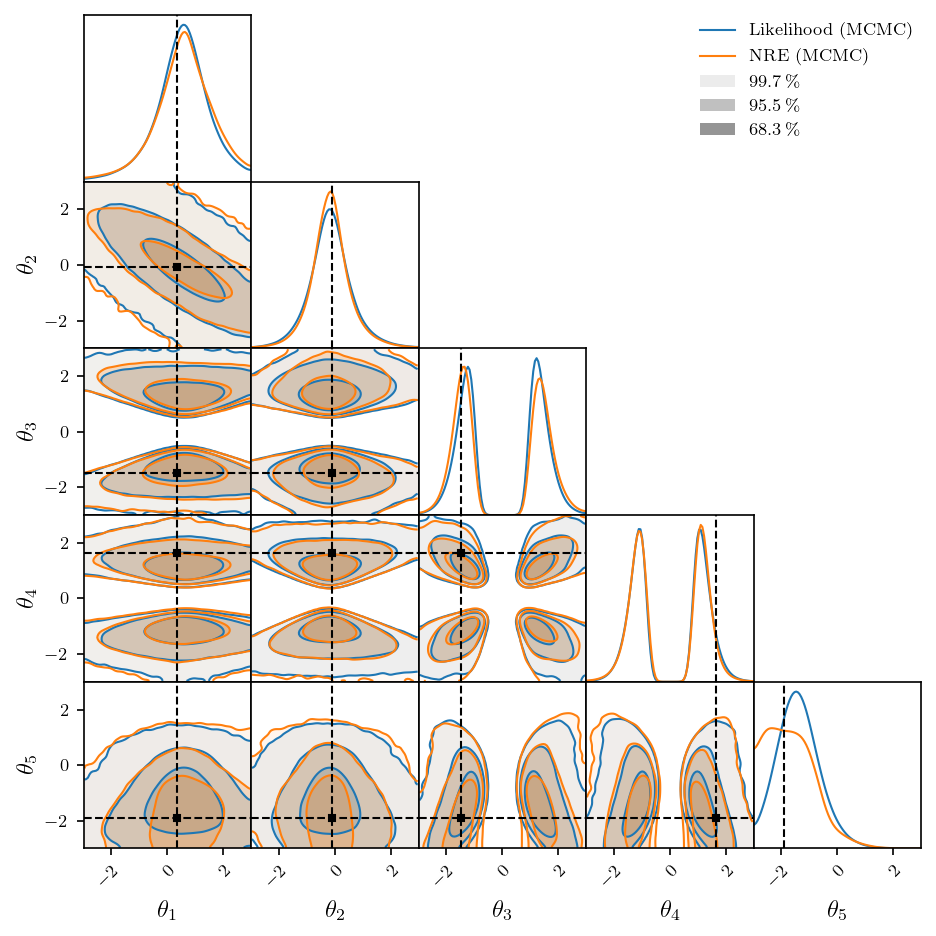

In [11]:
bounds = (sim.lower.cpu().numpy(), sim.upper.cpu().numpy())

fig = corner(
    thetas.numpy(),
    smooth=2.,
    bounds=bounds,
    labels=sim.labels,
    legend='Likelihood (MCMC)',
    markers=[theta.cpu().numpy()],
)

fig = corner(
    nre_thetas.numpy(),
    smooth=2.,
    bounds=bounds,
    legend='NRE (MCMC)',
    figure=fig,
)

## Save

In [12]:
writer.add_hparams(
    hparam_dict={
        'simulator': 'SLCP',
        'embedding': 'Flatten',
        'model': 'NRE',
        'layers': 5,
        'neurons_per_layer': 256,
        'activation': 'ELU',
        'epochs': 64,
        'optimizer': 'AdamW',
        'learning_rate': 1e-3,
        'weight_decay': 1e-3,
        'scheduler': 'ReduceLROnPlateau',
        'gamma': 0.5,
        'patience': 7,
        'gradient_clip': 1.,
    },
    metric_dict={
        'parameters': parameters,
        'batches_per_second': speed,
    },
)